## Setting up enviroment

### Importing libraries & connection to the database

In [2]:
import os
import io
import contextlib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

import ee
import geemap


from dotenv import load_dotenv
from pymongo import MongoClient
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from scipy import stats
from geemap import basemaps


In [3]:
load_dotenv()


True

Authenticating Google Earth Engine using GCP Service Key. 

In [4]:
resourcefile = 'eakey.json'

service_account = os.getenv('ee_service_account')
credentials = ee.ServiceAccountCredentials(service_account, resourcefile)
ee.Initialize(credentials, project=os.getenv('ee_project'))

For the chosen project, MongoDB has been selected as the primary database system due to the non-uniform characteristics of the utilized data. This decision was made to opt for a more flexible solution compared to PostgreSQL. The data is organized into several distinct collections. The provided code snippet initially establishes a connection to the database and subsequently interfaces with each individual collection. The database URL and name are dynamically loaded from the .env file.

In [5]:
db_url = os.getenv('DB_URL')
db_name = os.getenv('DB_NAME')

client = MongoClient(db_url)
db = client[db_name]

### Interfacing with collections.

In [6]:
collection = db['agriculture-and-rural-development_hti']

agricultural_dictionaries = {
       'agricultural_land_percentage' :{},
       'arable_land' :{},
       'rural_population_percentage' :{},
       'forest_area_percentage' :{},
       'forest_area_sq_km' :{},
       'crop_production_index' :{},
       'food_production_index' :{},
}

agricultural_indicators = {
       
       'agricultural_land_percentage':'Agricultural land (% of land area)',
       'arable_land': 'Arable land (% of land area)',
       'rural_population_percentage':'Rural population (% of total population)',
       'forest_area_percentage':'Forest area (% of land area)',
       'forest_area_sq_km':'Forest area (sq. km)',
       'crop_production_index':'Crop production index (2014-2016 = 100)',
       'food_production_index':'Food production index (2014-2016 = 100)',      
       


}

for dictionary in agricultural_dictionaries:
    for doc in collection.find({"Indicator Name": agricultural_indicators[dictionary]}, {"Year": 1, "Value": 1}):
        year = doc["Year"]
        value = doc["Value"]
        agricultural_dictionaries[dictionary][year] = value


collection = db['marketprices']

market_dictionaries = {
       'rice': {},
       'beans': {},
       'wheat_flour': {},
       'refined_vegetable_oil': {},     
}

market_indicators = {
       'rice': 'Rice (4% Broken)',
       'beans': 'Beans (Black)',
       'wheat_flour': 'Wheat Flour',
       'refined_vegetable_oil': 'Refined Vegetable Oil',     

}    

for dictionary in market_dictionaries:
       for doc in collection.find({"product": market_indicators[dictionary]}, {"period_date": 1, "value": 1}):
              period_date = doc["period_date"]
              value = doc["value"]
              market_dictionaries[dictionary][period_date] = value

collection = db['food_security_indicators']

food_security_dictionaries = {
       'gross_domestic_product': {},
       'food_production': {},
       'food_supply_variability': {},
       'basic_drinking_water': {},
}

food_security_indicators = {
       'gross_domestic_product': 'Gross domestic product per capita, PPP, (constant 2017 international $)',
       'food_production': 'Per capita food production variability (constant 2014-2016 thousand int$ per capita)',
       'food_supply_variability': 'Per capita food supply variability (kcal/cap/day)',
       'basic_drinking_water': 'Percentage of population using at least basic drinking water services (percent)',     
}

for dictionary in food_security_dictionaries:
       for doc in collection.find({"Item": food_security_indicators[dictionary]}, {"Year": 1, "Value": 1}):
              year = doc["Year"]
              value = doc["Value"]
              food_security_dictionaries[dictionary][year] = value

collection = db['undernourishment']

undernourishment_dictionaries = {
      'people_undernourished': {},
      
}

undernourishment_indicators = {
       'people_undernourished': 'Number of people undernourished (million) (3-year average)',
       
}

for dictionary in undernourishment_dictionaries:
    for doc in collection.find({"Item": undernourishment_indicators[dictionary], "Area": "Haiti"}, {"Year": 1, "Value": 1}):
        year = doc["Year"]
        value = doc["Value"]
        undernourishment_dictionaries[dictionary][year] = value

collection = db['value_food_imports_in_total_exports']

value_food_imports_dictionaries = {
      'value_food_imports': {},
      'value_food_imports_haiti': {},
      'value_food_imports_usa': {},
      'value_food_imports_germany': {},
}
value_food_imports_indicators = {
       'value_food_imports': 'Value of food imports in total merchandise exports (percent) (3-year average)',
}

# Only keys that are present in both dictionaries
common_keys = set(value_food_imports_dictionaries.keys()).intersection(value_food_imports_indicators.keys())

#Haiti
for dictionary in common_keys:
    for doc in collection.find({"Item": value_food_imports_indicators[dictionary], "Area": "Haiti"}, {"Year": 1, "Value": 1}):
        year = doc["Year"]
        value = doc["Value"]
        value_food_imports_dictionaries['value_food_imports_haiti'][year] = value
#USA
for dictionary in common_keys:
    for doc in collection.find({"Item": value_food_imports_indicators[dictionary], "Area": "United States of America"}, {"Year": 1, "Value": 1}):
        year = doc["Year"]
        value = doc["Value"]
        value_food_imports_dictionaries['value_food_imports_usa'][year] = value
      
#Germany
for dictionary in common_keys:
    for doc in collection.find({"Item": value_food_imports_indicators[dictionary], "Area": "Germany"}, {"Year": 1, "Value": 1}):
        year = doc["Year"]
        value = doc["Value"]
        value_food_imports_dictionaries['value_food_imports_germany'][year] = value

collection = db['climate-change_hti']

climate_change_dictionaries = {'co2_emissions': {}, 'mortality_under_five': {}}

climate_change_indicators = {'co2_emissions': 'CO2 emissions (kt)', 'mortality_under_five': 'Mortality rate, under-5 (per 1,000 live births)'}

for dictionary in climate_change_dictionaries:
       for doc in collection.find({"Indicator Name": climate_change_indicators[dictionary]}, {"Year": 1, "Value": 1}):
              year = doc["Year"]
              value = doc["Value"]
              climate_change_dictionaries[dictionary][year] = value

     


### Constructing Data Frames

In [7]:
df_agricultural_developement = pd.DataFrame(agricultural_dictionaries)
df_market_prices = pd.DataFrame(market_dictionaries)
df_food_security = pd.DataFrame(food_security_dictionaries)
df_undernourishment = pd.DataFrame(undernourishment_dictionaries)
df_co2_emissions = pd.DataFrame(climate_change_dictionaries)

'''
 I' am grouping marketprices data by year and taking the mean of the prices for each year,
 as other data is inceremented yearly instead of weekly, which was the case for marketprices data.
'''

# Averaging data to yearly increments

df_market_prices.index = pd.to_datetime(df_market_prices.index)
df_market_prices_yearly = df_market_prices.groupby(df_market_prices.index.year).mean()


# Here I am converting columns to numeriv values and non-numeric will be set to NaN

df_undernourishment = df_undernourishment.apply(pd.to_numeric, errors='coerce')

# Averaging data to yearly increments
df_undernourishment.index = df_undernourishment.index.astype(str).str[:4]
df_undernourishment.index = pd.to_datetime(df_undernourishment.index, format='%Y')
df_undernourishment_yearly = df_undernourishment.resample('Y').mean()



# At this point I have decided to smooth data

df_agricultural_developement_smoothed = df_agricultural_developement.rolling(3).mean()
df_market_prices_smoothed = df_market_prices_yearly.rolling(3).mean()
df_food_security_smoothed = df_food_security.rolling(3).mean()
df_undernourishment_yearly_smoothed = df_undernourishment_yearly.rolling(3).mean()
df_undernourishment_yearly_smoothed.index = df_undernourishment_yearly_smoothed.index.year
df_co2_emissions_smoothed = df_co2_emissions.rolling(3).mean()


# And sort by year

df_agricultural_developement_smoothed = df_agricultural_developement_smoothed.sort_index()
df_market_prices_smoothed = df_market_prices_smoothed.sort_index()
df_food_security_smoothed = df_food_security_smoothed.sort_index()
df_undernourishment_smoothed = df_undernourishment_yearly_smoothed.sort_index()
df_co2_emissions_smoothed = df_co2_emissions_smoothed.sort_index()

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------- #

# Data for Value Food Imports in Total Exports for Haiti, USA and Germany 



df_value_food_import_haiti = pd.DataFrame(list(value_food_imports_dictionaries['value_food_imports_haiti'].items()), columns=['Year', 'Value'])
df_value_food_import_usa = pd.DataFrame(list(value_food_imports_dictionaries['value_food_imports_usa'].items()), columns=['Year', 'Value'])
df_value_food_import_germany = pd.DataFrame(list(value_food_imports_dictionaries['value_food_imports_germany'].items()), columns=['Year', 'Value'])




df_value_food_import_haiti['Country'] = 'Haiti' 
df_value_food_import_usa['Country'] = 'United States of America'
df_value_food_import_germany['Country'] = 'Germany'




#--------------------------------USA---------------------------------#


df_value_food_import_usa['Value'] = pd.to_numeric(df_value_food_import_usa['Value'], errors='coerce') # Converting 'Value' to numeric


df_value_food_import_usa['Year'] = df_value_food_import_usa['Year'].str.split('-').str[0] # Extracting the start year from the 'Year' column


df_value_food_import_usa['Year'] = pd.to_datetime(df_value_food_import_usa['Year'], format='%Y') # Converting the 'Year' to datetime


df_value_food_import_usa = df_value_food_import_usa.set_index('Year') # Setting 'Year' as the index

df_value_food_import_usa.index = df_value_food_import_usa.index.year

df_value_food_import_usa = df_value_food_import_usa.sort_index()


#---------------------------- Germany---------------------------------#

df_value_food_import_germany['Value'] = pd.to_numeric(df_value_food_import_germany['Value'], errors='coerce')


df_value_food_import_germany['Year'] = df_value_food_import_germany['Year'].str.split('-').str[0]

df_value_food_import_germany['Year'] = pd.to_datetime(df_value_food_import_germany['Year'], format='%Y')


df_value_food_import_germany = df_value_food_import_germany.set_index('Year')

df_value_food_import_germany.index = df_value_food_import_germany.index.year

df_value_food_import_germany = df_value_food_import_germany.sort_index()

#------------------------------ Haiti----------------------------------#


df_value_food_import_haiti['Value'] = pd.to_numeric(df_value_food_import_haiti['Value'], errors='coerce')


df_value_food_import_haiti['Year'] = df_value_food_import_haiti['Year'].str.split('-').str[0]

df_value_food_import_haiti['Year'] = pd.to_datetime(df_value_food_import_haiti['Year'], format='%Y')


df_value_food_import_haiti = df_value_food_import_haiti.set_index('Year')

df_value_food_import_haiti.index = df_value_food_import_haiti.index.year

df_value_food_import_haiti = df_value_food_import_haiti.sort_index()



### Marketprices Statistics

Descriptive Statistics:

* Central tendency
* Measures of dispersion

Correlation Analysis

Covariance Analysis 

Predictive Modeling: How prices could change in the future if no action is taken.

#### Descriptive Statistics using pandas



In [ ]:
# Here I have decided to check central tendency of the marketprices data

df_market_prices_smoothed.describe()


In [ ]:
# And to measurre variance
df_market_prices_smoothed.var()

#### Corellation and Covariance between prices of the products.

Correlation


In [ ]:
# Correlation between prices of different products

df_market_prices_smoothed.corr()

correlation_matrix = df_market_prices_smoothed.corr()

plt.figure(figsize=(10,8)) # You can adjust the size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Market Prices in Haiti')
plt.show()

Covariance

In [ ]:
# Covariance between prices of different products

df_market_prices_smoothed.cov()

covariance_matrix = df_market_prices_smoothed.cov()

plt.figure(figsize=(10,8)) # You can adjust the size as needed
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm')
plt.title('Covariance Matrix of Market Prices in Haiti')
plt.show()

Line Plot, representing changes of market prices for Rice, Beans (Black), Wheat Flour and Refined Vegetable Oil in Haiti between 2008 and 2022

In [ ]:
linestyle = 'dashdot'

plt.figure(figsize=(14, 7))

sns.lineplot(data=df_market_prices_smoothed['rice'], label='Rice', color='red', linestyle=linestyle, marker='o')
sns.lineplot(data=df_market_prices_smoothed['beans'], label='Beans (Black)', color='purple', linestyle=linestyle, marker='o')
sns.lineplot(data=df_market_prices_smoothed['wheat_flour'], label='Wheat Flour', color='blue', linestyle=linestyle, marker='o')
sns.lineplot(data=df_market_prices_smoothed['refined_vegetable_oil'], label='Refined Vegetable Oil', color='orange', linestyle=linestyle, marker='o')

plt.xticks(rotation='vertical')
plt.title('Market Prices in Haiti')
plt.ylabel('Price in HTG (Haitian Gourde) per 6lb and a Gallon for oil')
plt.xlabel('Year')
plt.show()

### Population Statistics

##### Rural Population

In [9]:
rural_population_percentage = df_agricultural_developement_smoothed['rural_population_percentage']


Change over time, 2000 - 2018

-30.163537250151425

It is important to mention that since 2019 there is a large increase of rural population in Haiti. 

In [14]:
rural_population_change_2000 = rural_population_percentage['2000']
rural_population_change_2018 = rural_population_percentage['2018']

rural_population_change = (rural_population_change_2018 - rural_population_change_2000) / rural_population_change_2000 * 100

rural_pop = rural_population_percentage['2000':'2022']



rural_pop = rural_pop.rolling(3).mean()


In [ ]:
plt.figure(figsize=(14, 7))

sns.lineplot(data=rural_pop, label='Rural Population Percentage', color='red', linestyle='dashed')

plt.xticks(rotation='vertical')
plt.title('Rural Population Percentage in Haiti')
plt.ylabel('Percentage')
plt.xlabel('Year')
plt.show()

##### Population Total

### Undernourishment Statics

In [ ]:
import matplotlib.ticker as ticker

undernourishment = df_undernourishment_smoothed['people_undernourished']
undernourishment.index = undernourishment.index.astype(int)
undernourishment.iloc[0:2] = undernourishment.loc[2002]

plt.figure(figsize=(14, 7))
sns.lineplot(x=undernourishment.index, y=undernourishment.values, color='red', linestyle="dashed")

plt.title('Number of People Undernourished in Haiti')
plt.ylabel('Number of People in millions')
plt.xlabel('Year')

# Format x-axis labels as integers
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

plt.show()

In [ ]:
undernourishment

#### Descritptive statistics

In [ ]:
df_undernourishment_smoothed.describe()

In [ ]:
df_undernourishment_smoothed.var()

#### Correlation between Undernourishment and Market Prices

In [70]:
#combining dataframes

df_undernourishment_market_prices = pd.concat([df_undernourishment_smoothed, df_market_prices_smoothed], axis=1)

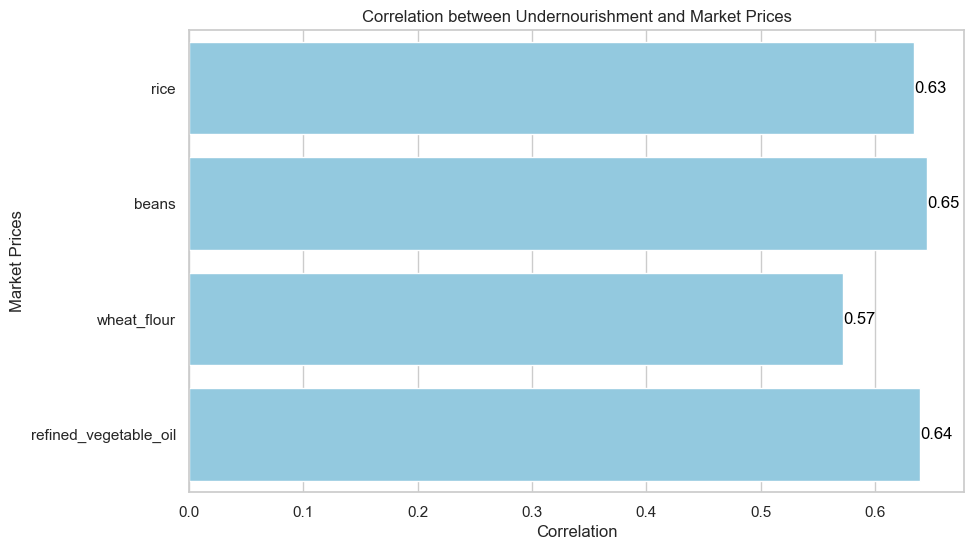

In [71]:

correlation_matrix = df_undernourishment_market_prices.corr()


correlation_with_undernourishment = correlation_matrix.iloc[0]


if 'people_undernourished' in correlation_with_undernourishment:
    correlation_with_undernourishment = correlation_with_undernourishment.drop('people_undernourished')

plt.figure(figsize=(10, 6))
barplot = sns.barplot(y=correlation_with_undernourishment.index, x=correlation_with_undernourishment.values, color='skyblue', orient='h')
plt.title('Correlation between Undernourishment and Market Prices')
plt.ylabel('Market Prices')
plt.xlabel('Correlation')


for i, v in enumerate(correlation_with_undernourishment.values):
    plt.text(v, i, f"{v:.2f}", color='black', va='center')

plt.show()

#### Covariance of Market prices and undernourishment

In [ ]:
covariance_matrix = df_undernourishment_market_prices.cov()
covariance_matrix

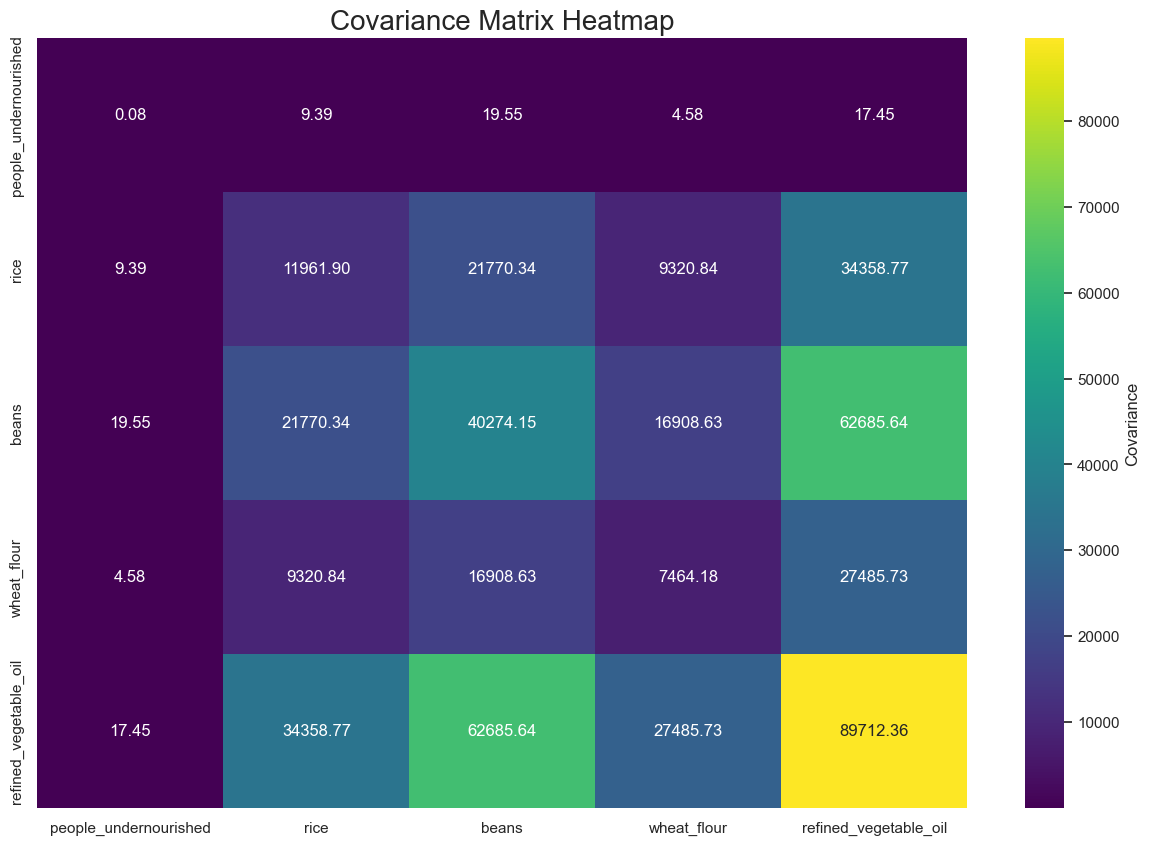

In [79]:
plt.figure(figsize=(15, 10))  # Size of the figure

# Create the heatmap with a different color map and a color bar
sns.heatmap(covariance_matrix, annot=True, fmt=".2f", cmap='viridis', cbar_kws={'label': 'Covariance'})

# Set the title with a larger font size
plt.title('Covariance Matrix Heatmap', fontsize=20)


plt.show()

#### Linear Regression between Undersnourishment and Marketprices

* slope: This is the slope of the regression line, which represents the relationship between 'people_undernourished' and 'rice'. If the slope is positive, it means that as the number of undernourished people increases, the price of rice also increases, and vice versa.

* intercept: This is the y-intercept of the regression line. It represents the expected value of 'rice' when 'people_undernourished' is 0.

* r_value: This is the correlation coefficient, which measures the strength and direction of the linear relationship between 'people_undernourished' and 'rice'. Its value ranges from -1 to 1, where 1 means a perfect positive correlation, -1 means a perfect negative correlation, and 0 means no correlation.

* p_value: This is the two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic. A low p-value (< 0.05) indicates that you can reject the null hypothesis. In other words, it suggests that there is a significant relationship between 'people_undernourished' and 'rice'.

* std_err: This is the standard error of the estimated gradient. It measures the accuracy of the slope of the regression line. The lower the standard error, the more accurate the slope is likely to be.

Undernourishment and Price of Rice

In [ ]:
rice_cleaned_df = df_undernourishment_market_prices.dropna()

slope, intercept, r_value, p_value, std_err = stats.linregress(rice_cleaned_df['rice'], rice_cleaned_df['people_undernourished'])

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")

Undernourishment and Price of Wheat Flour


In [ ]:
wheat_flour_cleaned_df = df_undernourishment_market_prices.dropna()

slope, intercept, r_value, p_value, std_err = stats.linregress(wheat_flour_cleaned_df['wheat_flour'], wheat_flour_cleaned_df['people_undernourished'])

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")

Undernourishment and Price of Beans (Black)


In [ ]:
beans_cleaned_df = df_undernourishment_market_prices.dropna()

slope, intercept, r_value, p_value, std_err = stats.linregress(beans_cleaned_df['beans'], beans_cleaned_df['people_undernourished'])

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")

Undernourishment and Price Refined Vegetable Oil


In [ ]:
oil_cleaned_df = df_undernourishment_market_prices.dropna()

slope, intercept, r_value, p_value, std_err = stats.linregress(oil_cleaned_df['refined_vegetable_oil'], oil_cleaned_df['people_undernourished'])

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")

#### Visualization of Linear Regression between Undersnourishment and Marketprices

##### Rice


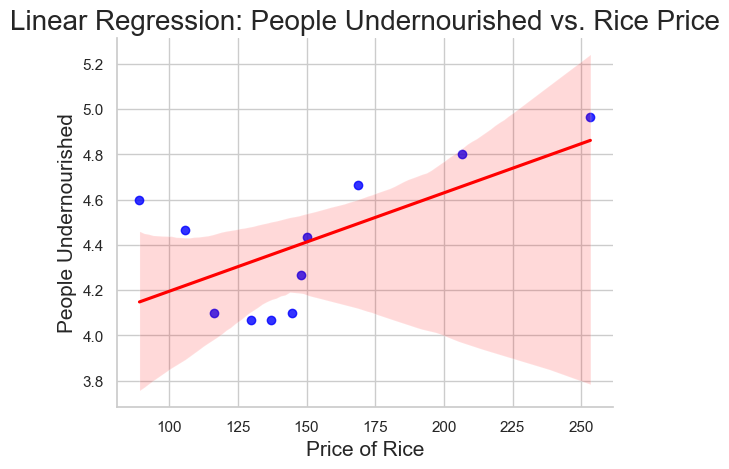

In [104]:
sns.set_style("whitegrid")

# Create a scatter plot with a linear regression model fit
plot = sns.regplot(x='rice', y='people_undernourished', data=rice_cleaned_df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})

# Set the title and labels for the plot
plt.title('Linear Regression: People Undernourished vs. Rice Price', fontsize=20)
plt.xlabel('Price of Rice', fontsize=15)
plt.ylabel('People Undernourished', fontsize=15)

# Remove the top and right spines from plot
sns.despine()

plt.show()

##### Wheat Flour

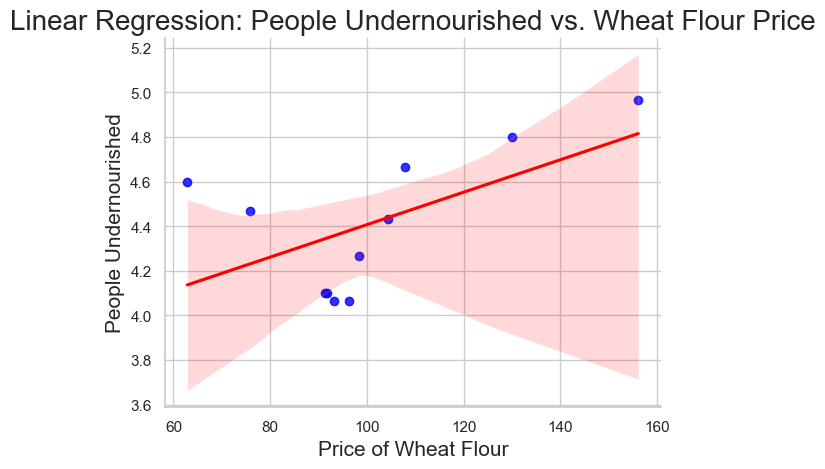

In [105]:
sns.set_style("whitegrid")
plot = sns.regplot(x='wheat_flour', y='people_undernourished', data=wheat_flour_cleaned_df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})


plt.title('Linear Regression: People Undernourished vs. Wheat Flour Price', fontsize=20)
plt.xlabel('Price of Wheat Flour', fontsize=15)
plt.ylabel('People Undernourished', fontsize=15)


sns.despine()

plt.show()

##### Beans (Black)

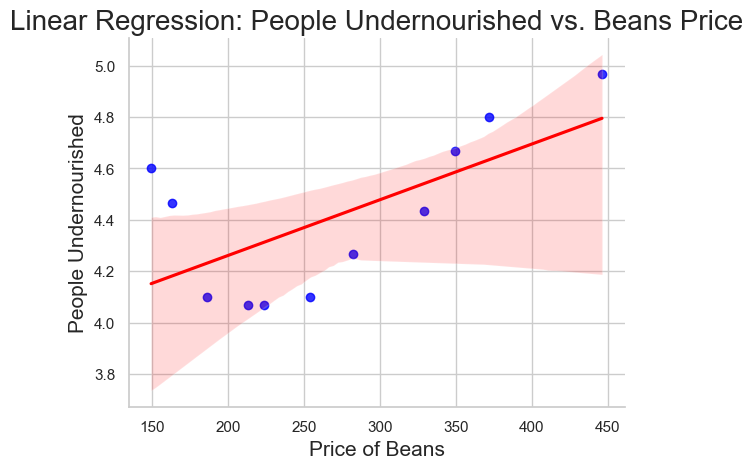

In [108]:

sns.set_style("whitegrid")


plot = sns.regplot(x='beans', y='people_undernourished', data=beans_cleaned_df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})

plt.title('Linear Regression: People Undernourished vs. Beans Price', fontsize=20)
plt.xlabel('Price of Beans', fontsize=15)
plt.ylabel('People Undernourished', fontsize=15)


sns.despine()

plt.show()

##### Refined Vegetable Oil

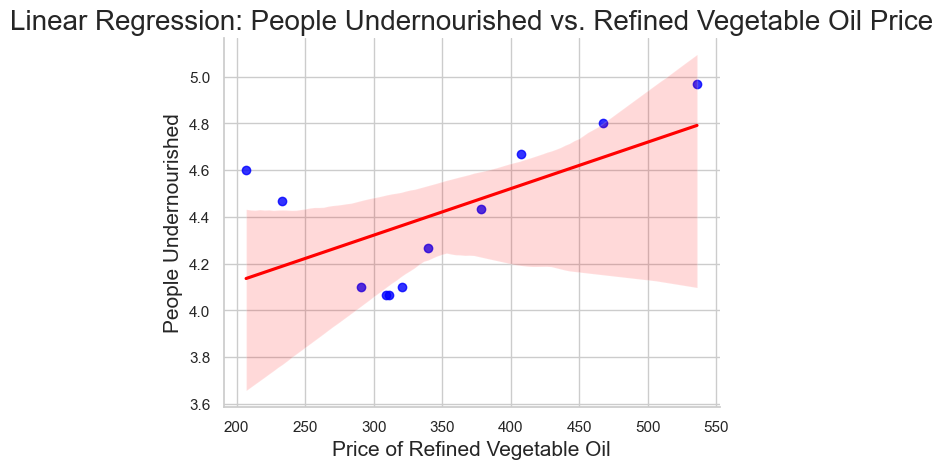

In [112]:

sns.set_style("whitegrid")


plot = sns.regplot(x='refined_vegetable_oil', y='people_undernourished', data=oil_cleaned_df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})


plt.title('Linear Regression: People Undernourished vs. Refined Vegetable Oil Price', fontsize=20)
plt.xlabel('Price of Refined Vegetable Oil', fontsize=15)
plt.ylabel('People Undernourished', fontsize=15)


sns.despine()

plt.show()

### Value of food imports in total merchandise exports (percent)

In [16]:
haiti_statistics_vfi=df_value_food_import_haiti.describe()
usa_statistics_vfi=df_value_food_import_usa.describe()
germany_statistics_vfi=df_value_food_import_germany.describe()


##### Visualize value of food imports in total merchandise exports

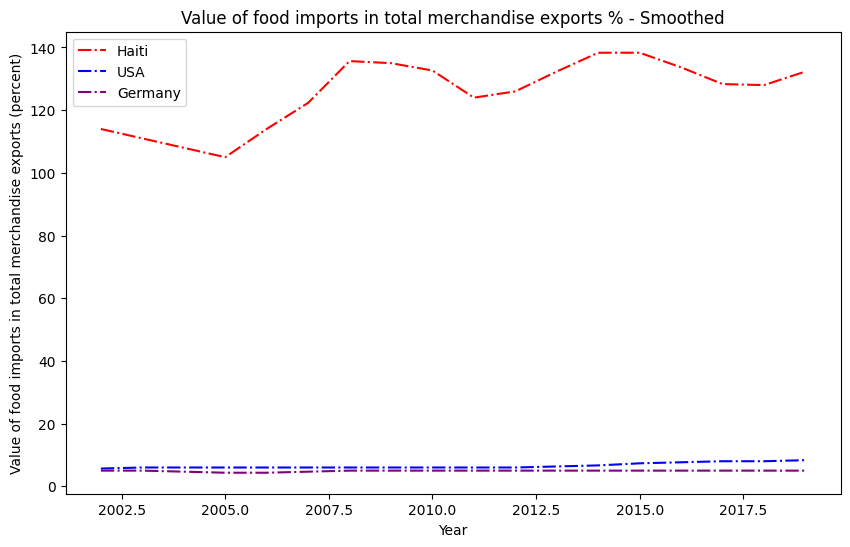

In [17]:
# Define the rolling window size
window_size = 3

# Apply the rolling mean
df_value_food_import_haiti['Value'] = df_value_food_import_haiti['Value'].rolling(window_size).mean()
df_value_food_import_usa['Value'] = df_value_food_import_usa['Value'].rolling(window_size).mean()
df_value_food_import_germany['Value'] = df_value_food_import_germany['Value'].rolling(window_size).mean()

# Plot the smoothed data
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_value_food_import_haiti, x='Year', y='Value', label='Haiti', linestyle='dashdot', color='red')
sns.lineplot(data=df_value_food_import_usa, x='Year', y='Value', label='USA', linestyle='dashdot', color='blue')
sns.lineplot(data=df_value_food_import_germany, x='Year', y='Value', label='Germany', linestyle='dashdot', color='purple')

plt.title('Value of food imports in total merchandise exports % - Smoothed')
plt.xlabel('Year')
plt.ylabel('Value of food imports in total merchandise exports (percent)')
plt.legend()
plt.show()

In [ ]:
df_value_food_import_haiti['Value']

##### Plot showing Value of food imports in total merchandise exports - Descriptive Statics

In [ ]:
# Transpose the dataframes
haiti_statistics_vfi = haiti_statistics_vfi.transpose().reset_index()
usa_statistics_vfi = usa_statistics_vfi.transpose().reset_index()
germany_statistics_vfi = germany_statistics_vfi.transpose().reset_index()

# Add a 'Country' column to each dataframe
haiti_statistics_vfi['Country'] = 'Haiti'
usa_statistics_vfi['Country'] = 'USA'
germany_statistics_vfi['Country'] = 'Germany'

# Concatenate the dataframes
statistics_vfi = pd.concat([haiti_statistics_vfi, usa_statistics_vfi, germany_statistics_vfi])

# Melt the dataframe to have 'Country', 'index', 'mean', 'std', 'min', '25%', '50%', '75%', 'max' as columns
statistics_vfi = pd.melt(statistics_vfi, id_vars=['Country', 'index'], value_vars=['mean', 'std', 'min', '25%', '50%', '75%', 'max'])

# Plot the data
plt.figure(figsize=(10, 6))
sns.catplot(data=statistics_vfi, x='index', y='value', hue='Country', col='variable', kind='bar', col_wrap=2)
plt.show()

### Food Security Indicators

#### Food Production Variability

In [14]:
food_production_variability = df_food_security_smoothed['food_production'].describe()
print(f"Per capita food production variability (constant 2014-2016 thousand int$ per capita)\n{food_production_variability}")


Per capita food production variability (constant 2014-2016 thousand int$ per capita)
count    18.000000
mean      5.220370
std       1.135991
min       3.933333
25%       4.233333
50%       5.033333
75%       5.883333
max       7.733333
Name: food_production, dtype: float64


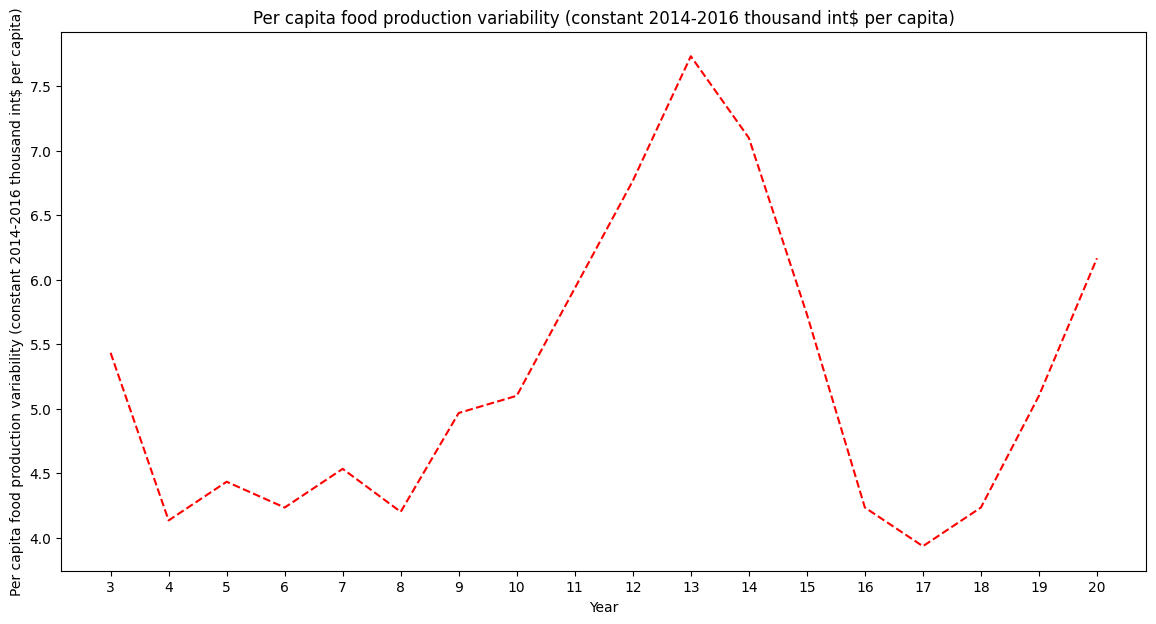

In [18]:
food_prduction = df_food_security_smoothed['food_production']




plt.figure(figsize=(14, 7))
sns.lineplot(x=food_prduction.index, y=food_prduction.values, color='red', linestyle="dashed")

plt.title('Per capita food production variability (constant 2014-2016 thousand int$ per capita)')
plt.ylabel('Per capita food production variability (constant 2014-2016 thousand int$ per capita)')
plt.xlabel('Year')

# Format x-axis labels as integers
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

plt.show()



In [ ]:
crop_production_index = df_agricultural_developement_smoothed['crop_production_index']
crop_production_index['2000':'2022']

In [ ]:
food_prduction_index = df_agricultural_developement_smoothed['food_production_index']
food_prduction_index['2000':'2022']

#### Food Supply Variability


In [ ]:
food_supply_variability = df_food_security_smoothed['food_supply_variability'].describe()
print(f"Per capita food supply variability (kcal/cap/day)\n{food_supply_variability}")

#### Drinking Water

In [16]:
basic_drinking_water = df_food_security_smoothed['basic_drinking_water'].describe()
print(f"Percentage of population using at least basic drinking water services (percent)\n{basic_drinking_water}")

Percentage of population using at least basic drinking water services (percent)
count    19.000000
mean     62.080702
std       2.797162
min      57.066667
25%      60.000000
50%      62.200000
75%      64.333333
max      66.300000
Name: basic_drinking_water, dtype: float64


### Deforestation Statistics

##### Interfacing data frames

forest_percentage - the amount of forest area to total area in percent
forest_sq_km - the amount of forest area in sq.km 

agricultural_land_percentage - the amount of land being cultivated
arable_land - the amount of total arable land



I have decided to check only a fragment of data available, between 2000 and 2018, because this period is available across all dataset used in this project, including satellite imagery dataset - Hansen Global Forest Change v1.10 (2000-2022)

In [20]:
forest_percentage = df_agricultural_developement_smoothed['forest_area_percentage']
forest_sq_km = df_agricultural_developement_smoothed['forest_area_sq_km']

agricultural_land_percentage = df_agricultural_developement_smoothed['agricultural_land_percentage']
arable_land = df_agricultural_developement_smoothed['arable_land']

##### Descriptive Statistics

Forest Area as Percentage of total area of Haiti

In [ ]:
forest_percentage.describe()

* count    30.000000
* mean     13.573632
* std       0.386670
* min      12.601597
* 25%      13.419394
* 50%      13.766382
* 75%      13.826098
* max      13.885813

In [22]:
forest_percentage.var()

0.149513989965097

* 0.149513989965097

Forest Change in percent over time between 1990 - 2018

Change in forest area  percentage from 1990 to 2018: -8.44%

In [23]:
forest_percentage_change1990 = forest_percentage['1990']
forest_percentage_change2018 = forest_percentage['2018']

forest_percentage_change = (forest_percentage_change2018 - forest_percentage_change1990) / forest_percentage_change1990 * 100

print(f"Change in forest area  percentage from 1990 to 2018: {forest_percentage_change:.2f}%")

Change in forest area  percentage from 1990 to 2018: -8.44%


Forest Area in square kilometers

In [24]:
forest_sq_km.describe()

count      30.000000
mean     3740.893000
std       106.566359
min      3473.000000
25%      3698.385000
50%      3794.015000
75%      3810.472500
max      3826.930000
Name: forest_area_sq_km, dtype: float64

* count      30.000000
* mean     3740.893000
* std       106.566359
* min      3473.000000
* 25%      3698.385000
* 50%      3794.015000
* 75%      3810.472500
* max      3826.930000

In [25]:
forest_sq_km.var()

11356.388932835245

* 11356.388932835245

Agricultural Land as percentage of total area of Haiti

In [26]:
agricultural_land_percentage.describe()

count    59.000000
mean     62.048492
std       5.418767
min      57.389937
25%      58.006773
50%      60.595065
75%      63.618771
max      75.036284
Name: agricultural_land_percentage, dtype: float64

* count    59.000000
* mean     62.048492
* std       5.418767
* min      57.389937
* 25%      58.006773
* 50%      60.595065
* 75%      63.618771
* max      75.036284

Agricultural Land as percentage - change over time between 1990 - 2018

Change in agricultural land percentage from 1990 to 2018: 16.93%

In [27]:
agricultural_land_percentage_1990 = agricultural_land_percentage['1990']
agricultural_land_percentage_2018 = agricultural_land_percentage['2018']

agricultural_land_percentage_change = (agricultural_land_percentage_2018 - agricultural_land_percentage_1990) / agricultural_land_percentage_1990 * 100

print(f"Change in agricultural land percentage from 1990 to 2018: {agricultural_land_percentage_change:.2f}%")

Change in agricultural land percentage from 1990 to 2018: 16.93%


Arable Land

In [28]:
arable_land.describe()

count    59.000000
mean     32.803619
std       5.001142
min      27.866473
25%      28.301887
50%      32.656023
75%      35.679729
max      42.815675
Name: arable_land, dtype: float64

* count    59.000000
* mean     32.803619
* std       5.001142
* min      27.866473
* 25%      28.301887
* 50%      32.656023
* 75%      35.679729
* max      42.815675

In [29]:
arable_land.var()

25.011416592033633

25.011416592033633

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=arable_land, color='blue', linestyle='dashdot')
plt.xticks(rotation='vertical')
plt.title('Arable Land in Haiti')
plt.ylabel('Percentage')
plt.xlabel('Year')
plt.show()


In [31]:
arable_land['2000':'2022']

2000    32.656023
2001    32.656023
2002    32.656023
2003    33.865506
2004    35.074988
2005    36.284470
2006    36.284470
2007    36.602927
2008    38.779995
2009    40.957063
2010    42.815675
2011    42.815675
2012    42.815675
2013    42.815675
2014    42.815675
2015    42.815675
2016    42.815675
2017    40.638607
2018    38.461538
2019    36.344944
2020          NaN
2021          NaN
2022          NaN
Name: arable_land, dtype: float64

### Statistics

#### Deforestaion / Drinking Water accessibility 

Data for years 2000, 2001 and 2021 for Basic Drinking Water Percentage (Percent of people with access to basic water services), was not-availabe. I have interpolated data for these years. 

In [8]:

water = df_food_security_smoothed['basic_drinking_water'].interpolate().fillna(method='bfill')
water = water['2000':'2018']

In [9]:
df_agricultural_developement = pd.DataFrame(agricultural_dictionaries)
forest_percentage = df_agricultural_developement['forest_area_percentage']
forest_percentage.index = forest_percentage.index.astype(int)
forest_percentage = forest_percentage.sort_index(ascending=True)
forest = forest_percentage.loc[2000:2018]


##### Correlation between forest area as percentage and access to basic water services. 

A Strong Negative correlation coefficient between these two sets, idicate inverse relationship. While these two variables move in opposite directions, it doesn't necessarily mean that changes in one cause changes in the other.

                        forest_area_percentage  basic_drinking_water
forest_area_percentage                1.000000             -0.885065
basic_drinking_water                 -0.885065              1.000000

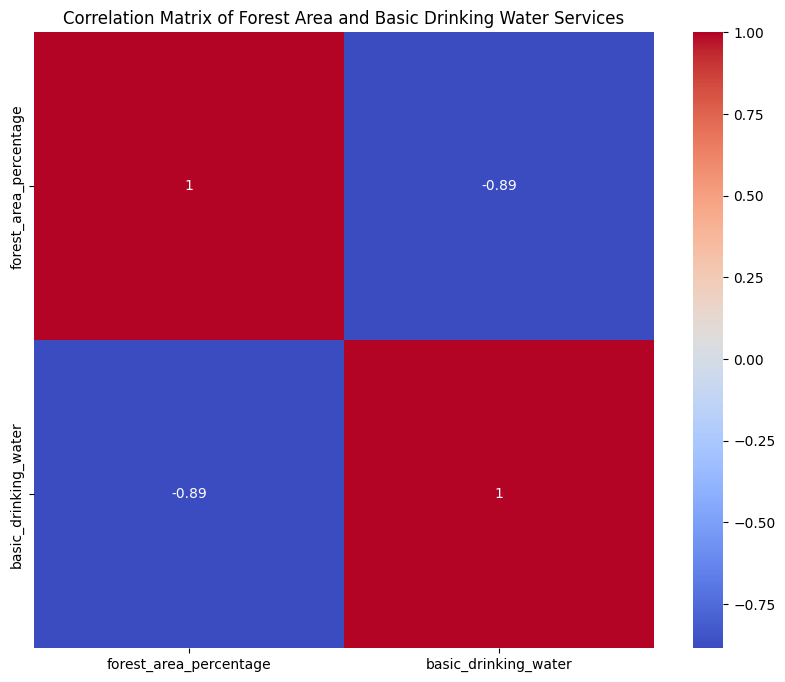

In [10]:
# Assuming forest and water are your original series
forest.index = forest.index.astype(int)
water.index = water.index.astype(int)

# Now, you can concatenate them
forest_water = pd.concat([forest, water], axis=1)



forest_water_corr = (forest_water.corr())

plt.figure(figsize=(10, 8))
sns.heatmap(forest_water_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Forest Area and Basic Drinking Water Services')
plt.show()

#### Deforestation / Undernourishment

Data in df_undernourishment_smoothed['people_undernourished'] for years 2000-2001 was missing, I have interpolated these rows with data from 2002

In [11]:
undernourishment = df_undernourishment_smoothed['people_undernourished']
undernourishment.index = undernourishment.index.astype(int)
undernourishment = undernourishment.loc[2000:2018]
undernourishment.iloc[0:2] = undernourishment.loc[2002]
undernourishment = undernourishment.interpolate(method='linear')

In [12]:
forest.index = forest.index.astype(int)
undernourishment.index = undernourishment.index.astype(int)

forest_undernourishment = pd.concat([forest, undernourishment], axis=1)

forest_undernourishment_corr = (forest_undernourishment.corr())

print(forest_undernourishment_corr)

                        forest_area_percentage  people_undernourished
forest_area_percentage                1.000000               0.235395
people_undernourished                 0.235395               1.000000


There is a very weak positive correlation between deforestation and undernoursihment. However in the next step I am going to check relation between Deforestation and food prices. 


                        forest_area_percentage  people_undernourished
forest_area_percentage                1.000000               0.235395
people_undernourished                 0.235395               1.000000

#### Deforestation / Food Production Variability / Food Supply Variability

data for food_supply_variability for years 2000 - 2001 is missing, I have interpolated it with data from 2002
data for food_production_variability for years 2000, 2001, 2002 is missing I have interpolated it with data from 2003

In [13]:
food_supply_variability = df_food_security_smoothed['food_supply_variability']
food_supply_variability.index = food_supply_variability.index.astype(int)
food_supply_variability = food_supply_variability.loc[2000:2018]
food_supply_variability.iloc[0:2] = food_supply_variability.loc[2002]
food_supply_variability = food_supply_variability.interpolate(method='linear')

food_production_variability = df_food_security_smoothed['food_production']
food_production_variability.index = food_production_variability.index.astype(int)
food_production_variability = food_production_variability.loc[2000:2018]
food_production_variability.iloc[0:3] = food_production_variability.loc[2003]
food_production_variability = food_production_variability.interpolate(method='linear')

In [14]:
food_supply_variability.index = food_supply_variability.index.astype(int)
food_production_variability.index = food_production_variability.index.astype(int)
forest.index = forest.index.astype(int)

supply_forest = pd.concat([food_supply_variability, forest], axis=1)
production_forest = pd.concat([food_production_variability, forest], axis=1)

supply_forest_corr = (supply_forest.corr())
production_forest_corr = (production_forest.corr())


The results of the corellation tests, are as follow:

There is a moderate positive corellation between food_supply_variabilty and forest_area_percentage

|                         | food_supply_variability | forest_area_percentage |
|------------------------ |-------------------------|------------------------|
| food_supply_variability | 1.000000                | 0.539196               |
| forest_area_percentage  | 0.539196                | 1.000000               |


Suggesting that with a reduction in forest area, food supply becomes more fluctuant (volatile).

There is practically no correlation between food production variability and forest area change, with a correlation coefficient of 0.004431. This suggests that deforestation hasn't increased production variability. It could imply that deforested areas either haven't been or weren't feasible to be transformed into farmlands. Additional tests are necessary to determine if there was a relationship between deforestation and changes in agriculture area.

#### Deforestation / Change in agriculture area

In [15]:
# Defining period of data to be used in the calculation. 
# I have decided to use data from 2000 to 2018 to be consistent with other data

df_agricultural_developement = pd.DataFrame(agricultural_dictionaries)
agri_area = df_agricultural_developement['agricultural_land_percentage']
agri_area.index = agri_area.index.astype(int)
agri_area.sort_index(inplace=True)
agri_area= agri_area.loc[2000:2018]

forest.index = forest.index.astype(int)


In [16]:
#Caclucating correlation between agricultural land and forest area

agri_forest = pd.concat([agri_area, forest], axis=1)
agri_forest_corr = (agri_forest.corr())

print(agri_forest_corr)

                              agricultural_land_percentage  \
agricultural_land_percentage                      1.000000   
forest_area_percentage                           -0.771259   

                              forest_area_percentage  
agricultural_land_percentage               -0.771259  
forest_area_percentage                      1.000000  


There is a strong negative corellation between these values, supporting previous observations that decrease in froest cover increases agriculture are coverage. However I am going to perform a casuality test. 

|                                 | agricultural_land_percentage | forest_area_percentage |
|---------------------------------|-----------------------------|-------------------------|
| **agricultural_land_percentage** |           1.000000            |       -0.771259          |
| **forest_area_percentage**       |          -0.771259           |        1.000000          |


In [17]:
data = pd.concat([agri_area, forest], axis=1)
data = data.apply(pd.to_numeric, errors='coerce')

# Fit a VAR model
data.index = pd.to_datetime(data.index, format='%Y')

# Now you can fit the VAR model and perform the Granger causality test
model = sm.tsa.VAR(data, dates=data.index, freq='AS-JAN')

# Dynamically set maxlags based on the number of observations
maxlags = int(pow(len(data), 1/3.0))

lag_order = model.select_order(maxlags=maxlags)
results = model.fit(maxlags=lag_order.aic)
granger_test = results.test_causality('forest_area_percentage', 'agricultural_land_percentage', kind='f')

'''
print(f"Causality: {granger_test.causing} -> {granger_test.caused}")
print(f"Test statistic: {granger_test.test_statistic}")
print(f"Significance level: {granger_test.signif}")
print(f"P-value: {granger_test.pvalue}")
print(f"Conclusion: {granger_test.conclusion}")
'''

'\nprint(f"Causality: {granger_test.causing} -> {granger_test.caused}")\nprint(f"Test statistic: {granger_test.test_statistic}")\nprint(f"Significance level: {granger_test.signif}")\nprint(f"P-value: {granger_test.pvalue}")\nprint(f"Conclusion: {granger_test.conclusion}")\n'

- **Causality:** ['agricultural_land_percentage'] -> ['forest_area_percentage']
- **Test Statistic:** 56.149742110831404
- **Significance Level:** 0.05
- **P-value:** 2.3644754044291593e-08
- **Conclusion:** Reject


The very small p-value (2.3644754044291593e-08) indicates that the observed results are highly unlikely under the assumption that there is no causal relationship. Therefore, at the 0.05 significance level, you reject the null hypothesis and infer that there is evidence of a causal relationship between 'agricultural_land_percentage' and 'forest_area_percentage'

#### Agricultural Land Change / Food Production Variability

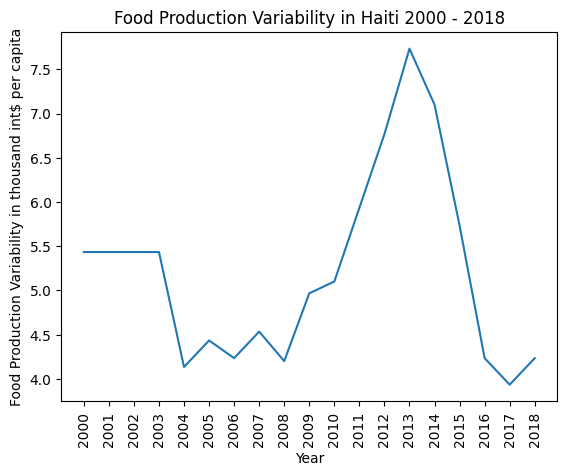

In [18]:

food_production = pd.to_numeric(food_production_variability , errors='coerce')


food_production .plot(kind='line')

plt.title('Food Production Variability in Haiti 2000 - 2018')
plt.xlabel('Year')
plt.ylabel('Food Production Variability in thousand int$ per capita')


plt.xticks(np.arange(min(food_production .index), max(food_production .index)+1, 1.0), rotation='vertical')

plt.show()

Plot showing Agricultural Land Area change over time


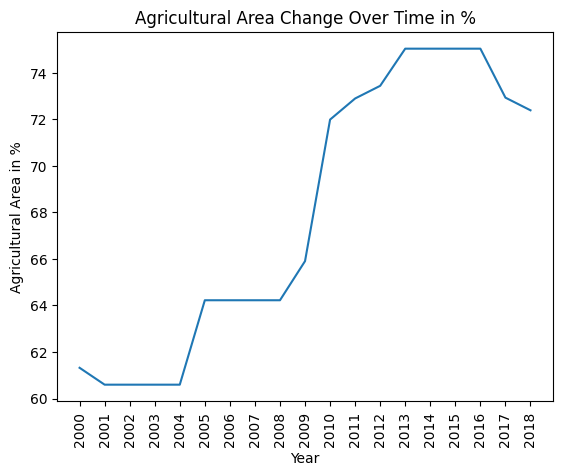

In [19]:

agri_area = pd.to_numeric(agri_area, errors='coerce')


agri_area.plot(kind='line')

plt.title('Agricultural Area Change Over Time in %')
plt.xlabel('Year')
plt.ylabel('Agricultural Area in %')


plt.xticks(np.arange(min(agri_area.index), max(agri_area.index)+1, 1.0), rotation='vertical')

plt.show()

In [20]:
agri_area = pd.to_numeric(agri_area, errors='coerce')
agri_food_production = pd.concat([agri_area, food_production_variability], axis=1)
agri_forest_corr = (agri_food_production.corr())
print(agri_forest_corr)

                              agricultural_land_percentage  food_production
agricultural_land_percentage                      1.000000         0.378089
food_production                                   0.378089         1.000000


In [21]:
print(agri_food_production.columns)

Index(['agricultural_land_percentage', 'food_production'], dtype='object')


In [23]:

# Drop any NaN values from the DataFrame
agri_food_production = agri_food_production.dropna()

# Reshape the data to the shape required by sklearn
X = agri_food_production['agricultural_land_percentage'].values.reshape(-1,1)
y = agri_food_production['food_production'].values

# Create a LinearRegression object
reg = LinearRegression()

# Fit the model to the data
reg.fit(X, y)

# Print the coefficients
print('Coefficient: ', reg.coef_)
print('Intercept: ', reg.intercept_)


'''
# Residual vs Fit values plot

y_pred = reg.predict(X)
residuals = y - y_pred


plt.scatter(y_pred, residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

'''

Coefficient:  [0.06895162]
Intercept:  0.5280298728067008


"\n# Residual vs Fit values plot\n\ny_pred = reg.predict(X)\nresiduals = y - y_pred\n\n\nplt.scatter(y_pred, residuals)\nplt.xlabel('Fitted values')\nplt.ylabel('Residuals')\nplt.title('Residuals vs Fitted values')\nplt.axhline(y=0, color='r', linestyle='-')\nplt.show()\n\n"

|                        | agricultural_land_percentage | food_production |
|------------------------|-----------------------------|------------------|
| **agricultural_land_percentage** |           1.000000            |        0.378089        |
| **food_production**                |           0.378089            |        1.000000        |


There is a weak to moderate correlation between values, suggesting a positive correlation between agricultural land percentage change and food production variability. As seen in the charts, it is crucial to emphasize that food production variability decreased rapidly from 2013, reaching its lowest point in 2017. This is important because 2016 and 2017 mark the years of the biggest deforestation in Haiti.

I assume that due to deforestation and the resulting desertification process, land erosion advanced rapidly, leading to minimal gains from food farming. Despite the increased percentage of agricultural areas, it illustrates that the quantity of farmlands couldn't overcome its weak quality attributes.

Historically, Haitian soil is not very nutritious, and over-farming of nutrient areas, along with soil erosion directly linked to deforestation, resulted in a crash in food production, pushing Haiti into even greater dependence on imported food.

#### CO2 Emissions / Food_Production Variability

In [29]:
co2_emissions = df_co2_emissions_smoothed['co2_emissions']
co2_emissions.index = co2_emissions.index.astype(int)
co2_emissions.sort_index(inplace=True)
co2_emissions = co2_emissions.loc[2000:2018]



CO2 Emissions in Haiti 2000-2018

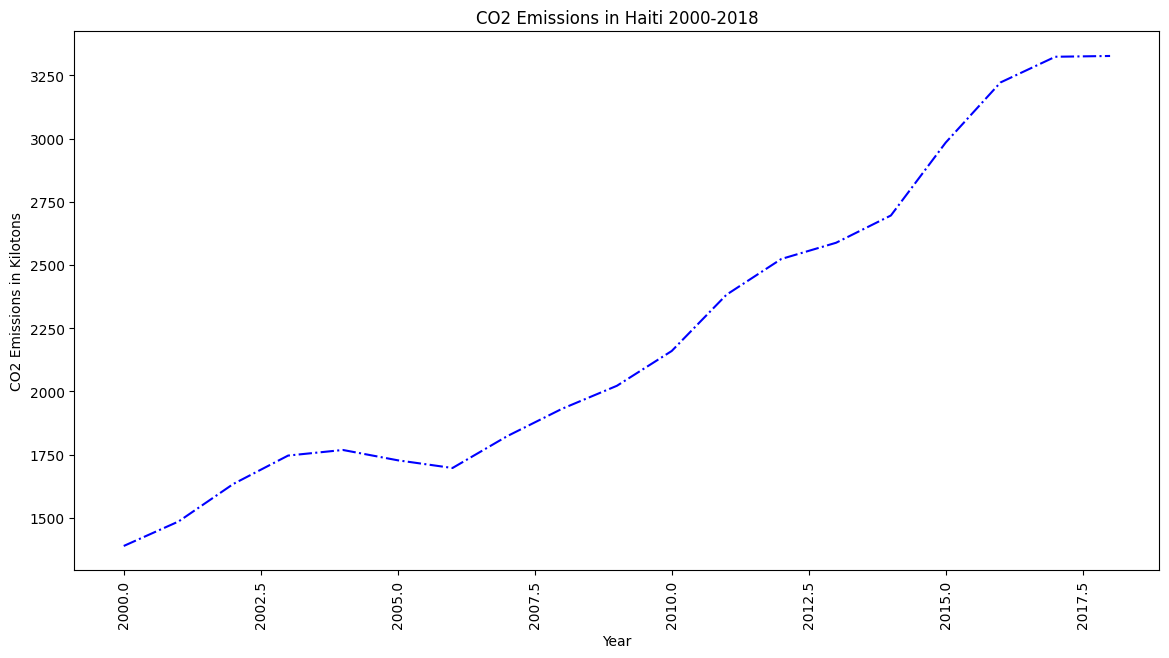

In [31]:
#Plot Co2 emissions

plt.figure(figsize=(14, 7))
sns.lineplot(data=co2_emissions, color='blue', linestyle='dashdot')
plt.xticks(rotation='vertical')
plt.title('CO2 Emissions in Haiti 2000-2018')
plt.ylabel('CO2 Emissions in Kilotons')
plt.xlabel('Year')
plt.show()


In [32]:
co2_food_production = pd.concat([co2_emissions, food_production_variability], axis=1)

co2_food_production_corr = (co2_food_production.corr())

print(co2_food_production_corr)

                 co2_emissions  food_production
co2_emissions         1.000000         0.060891
food_production       0.060891         1.000000
